## Adding new spectrographs

In this tutorial we are going to learn how to add a new spectrograph to `ACTIN`.

There are two main routes:

1. Forcing `ACTIN` to read a spectrograph from a specific `python` file.
2. Adding a new class to the `spectrographs` folder inside `ACTIN`, and the new spectrograph will be always available automatically.

#### Rules to create spectrograph classes:
- The file name and class names should be the same and be the name stored in the fits files under the keyword `INSTRUM`. For example, for HARPS-N, the file and class names are `HARPN` which is the instrument ID in the fits files.
- The class *must* have at least two attributes in the form of dictionaries called `spectrum` and `headers`, with the spectrum and fits headers data, respectively. The `spectrum` dictionary *must* contain the keys `wave` for the *stellar rest frame* wavelength, and `flux`, for the *deblazed* flux. The `headers` dictionary can be empty, if no information is required from the headers.
- The class `__init__` function *must* have a `hdu` positional argument, for the fits HDU, and *at least* a `**spec_kw` keyword argument to absorb other keyword arguments not used by the specific spectrograph class, such as the `file` argument which is used by the implemented spectrographs.

Let's suppose you want to calculate activity indices for `CORALIE`. You can retrieve the flux and wavelength and use `actin.CalcInd` as explained in the [Using ACTIN with any spectra](calc_act_general.ipynb) tutorial, or you can make your own spectrograph class.

Let's start by getting the `CORALIE` fits file.

In [1]:
import os
file = os.path.join(os.pardir, "actin2", "test", "CORALIE", "CORALIE.2004-02-19T06:22:20.001_s1d_A.fits")

Now suppose you created the following class to read the s1d spectra for `CORALIE`, and saved it somewhere with the name `CORALIE_new.py`:

```python
import numpy as np


spec_hdrs = dict(
    instr   = 'HIERARCH ESO OBS INSTRUMENT',
    bjd     = 'HIERARCH ESO DRS BJD',
    spec_rv = 'HIERARCH ESO OBS TARG RADVEL', # low precision RV [km/s]
    berv    = 'HIERARCH ESO DRS BERV', # Barycentric Earth Radial Velocity [km/s]    
)


class CORALIE_new:
    def __init__(self, hdu, **spec_kw):
        
        instr = 'CORALIE'

        # Create dictionary to hold the spectrum data
        spec = dict()

        # Obtain the flux and headers from fits HDU
        spec['flux_raw'] = hdu[0].data
        hdr = hdu[0].header
        hdu.close()

        # Calculate wavelength grid
        spec['wave_raw'] = hdr['CRVAL1'] + hdr['CDELT1'] * np.arange(hdr['NAXIS1'])

        # Get spectrum selected header values:        
        headers = {}
        for key, hdr_id in zip(spec_hdrs.keys(), spec_hdrs.values()):
            try:
                headers[key] = hdr[hdr_id]
            except KeyError:
                headers[key] = None

        headers['instr'] = instr

        # Convert RV and BERV to m/s
        for key in headers.keys():
            if key in ['spec_rv', 'berv']:
                headers[key] *= 1e3 # to m/s

        # Correct spectrum to stellar rest frame
        c = 299792458.0 # light velocity [m/s]
        dwave = headers['spec_rv'] * spec['wave_raw'] / c
        spec['wave'] = spec['wave_raw'] - dwave

        # Flux photon noise
        spec['flux_err'] = np.sqrt(abs(spec['flux_raw']))

        # s1d files already deblazed
        spec['flux'] = spec['flux_raw']


        # output:
        self.spectrum = spec      # spectrum dict (must have 'wave' and 'flux')
        self.headers = headers    # all selected headers dict
```

Note that the name of the file is the same as the class.

This class is available in the `test` folder of `ACTIN` and we will use it to read the file above.

In [2]:
spec_file_in = os.path.join(os.pardir, "actin2", "test", "CORALIE", "CORALIE_new.py")

And finally we will read the file while forcing `ACTIN` to use the new spectrograph class by using the `spec_kw` argument and `spec_file_in` and calculate an activity index, in this case using the sodium D2 lines, `I_NaI`:

In [3]:
from actin2 import ACTIN
actin = ACTIN()

actin.run(file, 'I_NaI', spec_kw=dict(spec_file_in=spec_file_in))

100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


instr           bjd  spec_rv         berv  \
0  CORALIE  2.453055e+06    930.0  15574.51973   

                                         file    I_NaI  I_NaI_err  I_NaI_Rneg  \
0  CORALIE.2004-02-19T06:22:20.001_s1d_A.fits  0.27232    0.00078         0.0   

      actin_ver  
0  2.0.0_beta_7

And check the index lines:

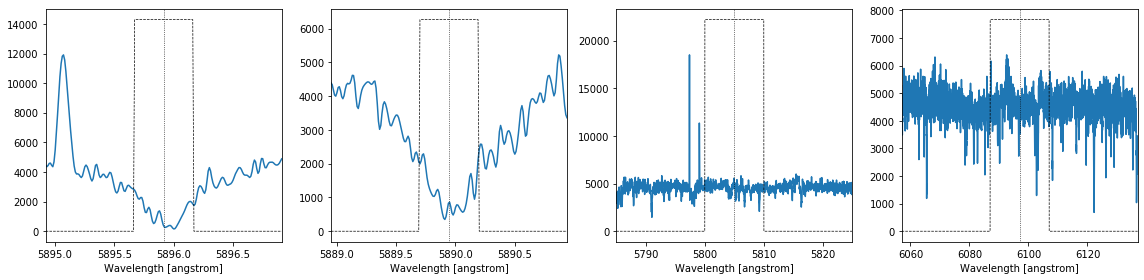

In [4]:
%matplotlib inline

actin.plot_index_lines(file, 'I_NaI', spec_kw=dict(spec_file_in=spec_file_in))

If you want `ACTIN` to recognise the new spectrograph automatically, you can save the `CORAlIE_new.py` file to the `actin2/spectrographs` directory. 